# Daymet mapping to NHM hrus
This notebook demonstrates the Daymet mapping/interpolating to NHM HRUs

In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
# import rasterio
import os
import xarray as xr
import json

Populating the interactive namespace from numpy and matplotlib


# Open Daymet max temperature with geopandas and plot

In [2]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../../Data_v1_1') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
# glob below is not necessary in this case as there is only one shapefile.  Will keep
# code this way as in the case of HRUs split into multiple shapefiles this is how to concatenate
# into one geodataframe

shapefiles = folder.glob("*2e*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
#print(gdf)

C:\Users\rmcd\git\onhm-fetcher-parser\notebooks\final_notebooks
..\..\Data_v1_1


# Open Daymet data (as netcdf file) 
https://daymet.ornl.gov/web_services

In [3]:
from pathlib import Path
dmPath = Path('../../Data_v1_1')
print('Daymet Path exists: ', dmPath.exists())
dmFile = Path(list(dmPath.glob('*_tmax_1980*.nc4'))[0])
ds = None
if dmFile.exists():
    ds_den = xr.open_dataset(dmFile)
#     dsday = ds.sel(time=slice('1980-01-01'))
#     ds2 = dsday.where((ds.lat >= 20) & (ds.lat <= 54) & (ds.lat >= -126) & (ds.lat <= -65))
    #delaware = temp.where((ds.lon>=-77) & (ds.lon<=-74) & (ds.lat>=38) & (ds.lat<=43), drop=True)-273.5
    print(ds_den)
else:
    print('Daymet file does not exist', dmFile)
    

Daymet Path exists:  True
<xarray.Dataset>
Dimensions:                  (nv: 2, time: 365, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-12-30T12:00:00
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for curr

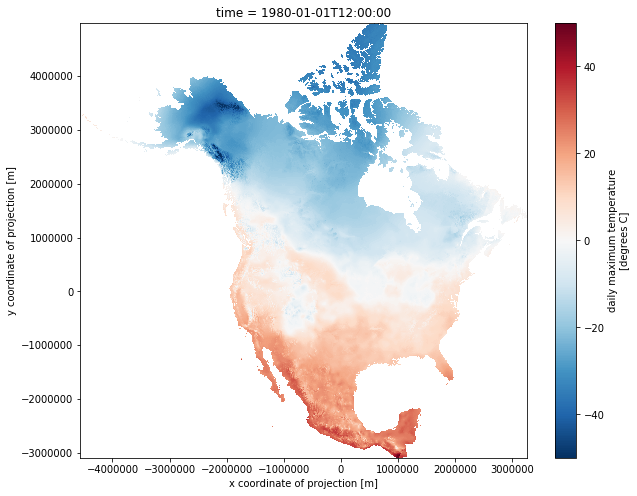

In [4]:
dsprcp = ds_den.tmax.sel(time='1980-01-01T12:00:00')
dsprcp.plot.imshow()
# plt.show()

In [5]:
import requests
from requests.exceptions import HTTPError
from datetime import datetime, timedelta
from urllib.parse import urlencode
from pathlib import Path
testfile = Path('tmax_test2.nc')
if not testfile.exists():
    prcpurl = 'https://thredds.daac.ornl.gov/thredds/ncss/daymet-v3-agg/na.ncml'
    prcppayload = {
    #     'var': 'lat&var=lon&var=tmax',
#         'var': 'lat&var=lon&var=prcp&var=srad&var=swe&var=tmax&var=tmin&var=vp',
        'var': 'lat&var=lon&var=tmax',
        'north': '54',
        'west': '-126',
        'east': '-65',
        'south': '20',
        'disableProjSubset': 'on',
        'horizStride': '1',
        'time_start': '1980-01-01T12:00:00Z',
        'time_end': '1980-01-01T12:00:00Z',
        'timeStride': '1',
        'accept': 'netcdf'}    
    try:
        s = requests.Session()
        #https://github.com/psf/requests/issues/1454
        qry = urlencode(prcppayload).replace('%26','&')
        qry = qry.replace('%3D', '=')
        print(qry)
        tmaxfile = requests.get(prcpurl, params=qry)
        tmaxfile.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occured: {http_err}')
    except Exception as err:
        print(f'Other error occured: {err}')
    else:
        print('Daymet data retrieved!')

    with open('tmax_test2.nc', 'wb') as fh:
        fh.write(tmaxfile.content)
    fh.close    

#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
# dirPath='https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_prcp_2018_na.nc4?var=lat&var=lon&var=prcp&north=52.880049298000074+&west=-124.72462483099997+&east=-66.94953853699997+&south=24.839424370000074&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00:00:00Z&time_end=2018-12-31T00:00:00Z&timeStride=1&accept=netcdf'
# fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'
# dirPath = 'tmax_test2.nc'
# dirPath = 'daymet_v3_tmax_2018_na.nc4.nc'
#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
# fullfilename= dirPath
# print(fullfilename)

ds = xr.open_dataset(testfile)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', ds.attrs)
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['time']
datahandle=ds['tmax']
dhlat = ds['lat']
dhlon = ds['lon']
crshandle=ds['lambert_conformal_conic']
print('\n The crs meta data is \n', crshandle.attrs)
print(datahandle)


#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n',datahandle.attrs)
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)
print('\n Lat coords are: \n', dhlat.attrs)

ts = datahandle.sizes
print(type(ts))
print(ts['time'])
dayshape = ts['time']
Lonshape = ts['x']
Latshape = ts['y']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)


<xarray.Dataset>
Dimensions:                  (time: 1, x: 6008, y: 3699)
Coordinates:
  * y                        (y) float32 1687.0 1686.0 ... -2010.0 -2011.0
  * x                        (x) float32 -2754.25 -2753.25 ... 3251.75 3252.75
  * time                     (time) datetime64[ns] 1980-01-01
Data variables:
    lat                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
    lon                      (y, x) float32 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    _NCProperties:       version=1|netcdflibversion=4.6.1|hdf5libversion=1.10.2
    start_year:          1980
    source:              Daymet Software Version 3.0
    Version_software:    Daymet Software Version 3.0
    Version_data:        Daymet Data Version 3.0
    Conventions:         CF-1.6
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor...
    title:           

In [6]:
lon = ds.lon.values
numcells = np.shape(lon)[0]*np.shape(lon)[1]
numcells

22223592

In [7]:
x_min = np.min(ds.x.values)
x_max = np.max(ds.x.values)
print(x_min, x_max)
y_min = np.min(ds.y.values)
y_max = np.max(ds.y.values)
print(y_min, y_max)

-2754.25 3252.75
-2011.0 1687.0


In [8]:
tx_min = ds.x.min()
tx_min

<xarray.DataArray 'x' ()>
array(-2754.25, dtype=float32)

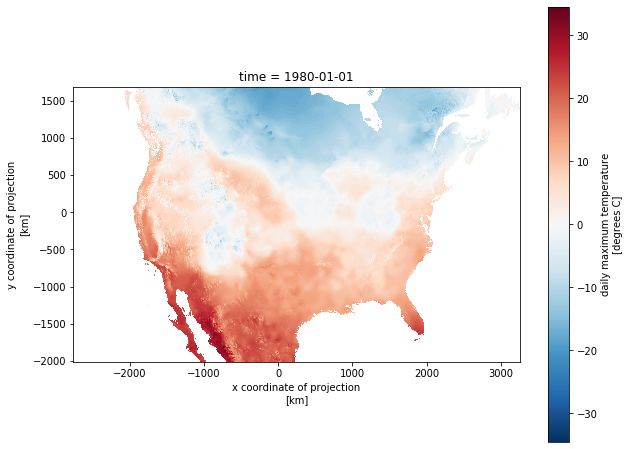

In [19]:
# ds.tmax.sel(time='2018-12-31')
p = ds.tmax.sel(time='1980-01-01').plot.imshow()
p.axes.set_aspect('equal')
plt.show()

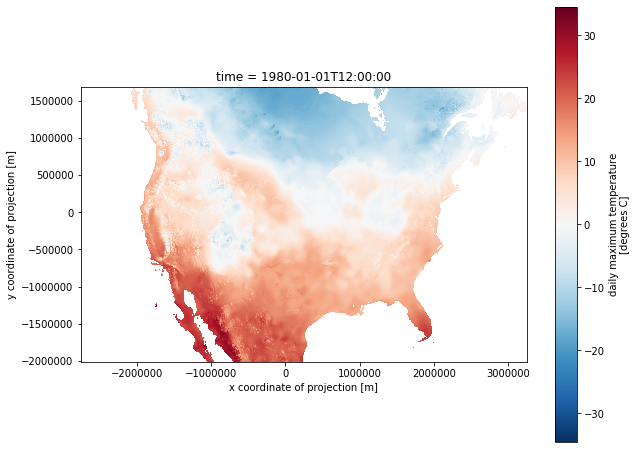

In [18]:
ds_dent = ds_den.tmax.sel(time='1980-01-01T12:00:00',
                         y=slice(y_max*1000.0, y_min*1000.0), x=slice(x_min*1000.0,x_max*1000.0) )
# ds_den_sel = ds_dent.where((ds_dent.x >= ds.x.min()*1000) & (ds_dent.x <= ds.x.max()*1000) & 
#                            (ds_dent.y >= ds.y.min()*1000) & (ds_dent.y <= ds.y.max()*1000))
# ds_den_sel = ds_dent.sel(x=slice(ds.x.min(),ds.x.max()), y=slice(ds.y.min(), ds.y.max()))
p = ds_dent.plot()
p.axes.set_aspect('equal')
plt.show()

In [21]:
ds_dent

<xarray.DataArray 'tmax' (y: 3699, x: 6008)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float32 -2754250.0 -2753250.0 ... 3251750.0 3252750.0
  * y        (y) float32 1687000.0 1686000.0 1685000.0 ... -2010000.0 -2011000.0
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
    time     datetime64[ns] 1980-01-01T12:00:00
Attributes:
    long_name:     daily maximum temperature
    units:         degrees C
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: maximum

In [20]:
ds_dent.values[]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [22]:
from numpy.ma import masked
# add tmax column to dataframe
gdf['tmax']=0.0
# gdf.tmax[noint] = 10.0
# print(gdf.tmax[noint])

wght_UofI = pd.read_csv('../../Data_v1_1/tmp_daymet_weights_hru_v1_1e.csv')
print(wght_UofI.head())
wghts_id = wght_UofI.columns[1]
print('wghts_id', wghts_id)
#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
# ndata = datahandle.values[dayshape-1,:,:].flatten(order='C')
# ndata = ds.tmax.values[dayshape-1,:,:].flatten()
lon = ds.lon.values
lat = ds.lat.values
ndata = np.zeros(np.shape(lon)[1]*np.shape(lon)[0])
tlc = 0
for i in range(1, np.shape(lon)[0] - 1):
    if i % 100 == 0: print(i, flush=True)
    for j in range(1, np.shape(lon)[1] - 1):
        ndata[tlc] = ds_dent.values[i,j]
        tlc+=1

# print(ndata[1000:])

unique_hru_ids = wght_UofI.groupby(wghts_id)
print(len(gdf), len(unique_hru_ids))

def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
def np_get_wval(ndata, wghts, hru_id):
    """
    Returns weighted average of ndata with weights = grp
    1) mdata = the subset of values associated with the gridmet id's that are mapped to hru_id.
    2) Some of these values may have nans if the gridmet id is outside of conus so only return values
    that are inside of conus
    3) this means that hru's that are entirely outside of conus will return nans which will ultimately,
    outside of this function get assigned zero's.
    4) the value is assigned the weighted average
    :param ndata: float array of data values
    :param wghts: float array of weights
    :param hru_id hru id number
    :return: numpy weighted averaged - masked to deal with nans associated with
            ndata that is outside of the conus.
    """
    mdata = np.ma.masked_array(ndata[wghts['grid_ids'].values.astype(int)],
                               np.isnan(ndata[wghts['grid_ids'].values.astype(int)]))

    # mdata = np.ma.masked_where(ndata[wghts['grid_ids'].values.astype(int)] <= 0.0,
    #                            (ndata[wghts['grid_ids'].values.astype(int)]))
    tmp = np.ma.average(mdata, weights=wghts['w'])
    if tmp is masked:
        # print('returning masked value', hru_id, mdata, wghts['w'])
        return np.nan

    else:
        return tmp
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
#     if not(row['nhm_id'] in noint):
    try: 
        weight_id_rows = unique_hru_ids.get_group(row[wghts_id])
        td[index] = np.nan_to_num(np_get_wval(ndata, weight_id_rows, index+1))
    except KeyError:
        td[index] = 0.0
            
            
#         gdf['tmax'][index] = np_get_wval2(weight_id_rows, ndata)
#     else:
#         td[index] = 10.0

gdf['tmax'] = td.tolist()
# gdf['tmax'].fillna(0.0)

print('min/max', gdf['tmax'].min(), gdf['tmax'].max())

# f, ax = plt.subplots(2, figsize=(12,12))
# gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white')
# ax[0].set_aspect('equal')
# ptmax = ds.tmax
# ptmax_1 = ptmax.isel(time=dayshape-1)
# lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
# ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')

   grid_ids  nhru_v11         w
0  17997007     76127  0.000885
1  17997011     76127  0.002030
2  17997010     76127  0.004571
3  17997009     76127  0.004744
4  17997008     76127  0.001928
wghts_id nhru_v11
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
139809 114958
min/max -13.667109587577722 24.5


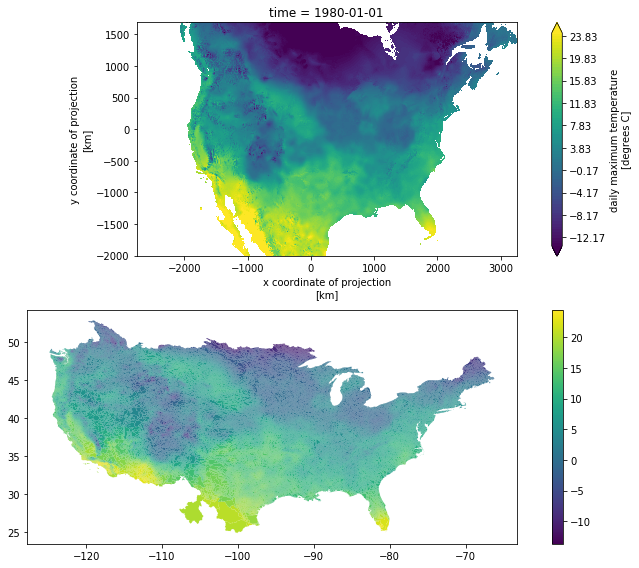

In [24]:
f, ax = plt.subplots(2, 1)

lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)

ptmax = ds.tmax
ptmax_1 = ptmax.isel(time=dayshape-1)
p=ptmax_1.plot(ax=ax[0], levels=lvs, cmap='viridis')
ax[0].set_aspect('equal', 'box')

g = gdf.plot(ax=ax[1], column = 'tmax',linewidth=0., edgecolor='white', legend=True)
# temp = ds.daily_maximum_temperature[0,:,:]-273.5
ax[1].set_aspect('equal', 'box')


plt.tight_layout()
plt.show()

##### lon = ds.lon.values
lat = ds.lat.values
print(np.shape(lon))

In [ ]:
wght_UofI.head()

In [ ]:
wght_sum = wght_UofI.groupby(wghts_id).sum()
print(type(wght_sum))
wght_sum.head()

In [ ]:
print(wght_sum.head(100))
wght_sum['w'][10000]
wght_sum.w.plot()
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
# print(wght_UofI.loc[wght_UofI['GFv11_id'] == 5])
# tid = 5
# hid = gdf.loc[gdf['GFv11_id']==tid].geometry.area.sum()
# print(hid)

In [ ]:
gdf_id = gdf.groupby('GFv11_id', sort = False)


In [ ]:
# print(gdf_id)
for index, row in gdf_id:
#     print(' ')
    if index < 6:
        print(len(row))
        for geo in row.geometry:
            print(index, row['GFv11_id'].values, geo.area, geo.bounds)
#             print(geo)
#         print(row['GFv11_id'], gdf_id.loc[gdf_id['GFv11_id']==row['GFv11_id']].geometry.area.sum())

In [ ]:
count = 0
for index, row in gdf.iterrows():
    if count < 5:
        print(gdf.loc[[index]])